# Анализ активности студентов онлайн курса 'Введение в анализ данных в R'. Подготовка данных

Проблема:  
Почему пользователи не заканчивают курс до конца?  
Как предсказать что пользователь бросит курс?  
Какими паттернами поведения обладают те, кто успешно заканчивает курсы и те, кто бросает?


Описание данных:  
event_data_train.csv - данные о действиях, которые совершают студенты со стэпами
* step_id - id стэпа
* user_id - анонимизированный id юзера
* timestamp - время наступления события в формате unix date
* action - событие, возможные значения:  
-- discovered - пользователь перешел на стэп  
-- viewed - просмотр шага,  
-- started_attempt - начало попытки решить шаг, ранее нужно было явно нажать на кнопку - начать решение, перед тем как приступить к решению практического шага  
-- passed - удачное решение практического шага  

submissions_data_train.csv - данные о времени и статусах сабмитов к практическим заданиям
* step_id - id стэпа
* timestamp - время отправки решения в формате unix date
* submission_status - статус решения
* user_id - анонимизированный id юзера

In [1]:
import pandas as pd

events_trains = pd.read_csv('./data/event_data_train.csv')
events_trains.head()

,step_id,timestamp,action,user_id
0,32815,1434340848,viewed,17632
1,32815,1434340848,passed,17632
2,32815,1434340848,discovered,17632
3,32811,1434340895,discovered,17632
4,32811,1434340895,viewed,17632


Выведем все возможные варианты поля action

In [2]:
events_trains.action.unique()

array(['viewed', 'passed', 'discovered', 'started_attempt'], dtype=object)

Преобразуем дату в читаемый вид и исследуем столбец

In [3]:
events_trains['date'] = pd.to_datetime(events_trains.timestamp, unit='s')
events_trains.head()

,step_id,timestamp,action,user_id,date
0,32815,1434340848,viewed,17632,2015-06-15 04:00:48
1,32815,1434340848,passed,17632,2015-06-15 04:00:48
2,32815,1434340848,discovered,17632,2015-06-15 04:00:48
3,32811,1434340895,discovered,17632,2015-06-15 04:01:35
4,32811,1434340895,viewed,17632,2015-06-15 04:01:35


In [4]:
events_trains.date.min()

Timestamp('2015-06-15 04:00:48')

In [5]:
events_trains.date.max()

Timestamp('2018-05-19 23:33:31')

In [6]:
events_trains['day'] = events_trains.date.dt.date
events_trains.head()

,step_id,timestamp,action,user_id,date,day
0,32815,1434340848,viewed,17632,2015-06-15 04:00:48,2015-06-15
1,32815,1434340848,passed,17632,2015-06-15 04:00:48,2015-06-15
2,32815,1434340848,discovered,17632,2015-06-15 04:00:48,2015-06-15
3,32811,1434340895,discovered,17632,2015-06-15 04:01:35,2015-06-15
4,32811,1434340895,viewed,17632,2015-06-15 04:01:35,2015-06-15


Выведем график количества уникальных пользователей по дням

<AxesSubplot:xlabel='day'>

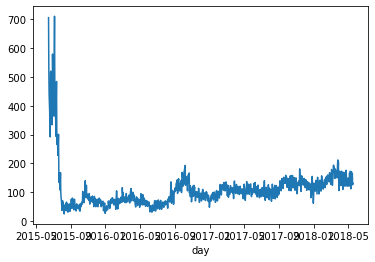

In [7]:
events_trains.groupby('day').user_id.nunique().plot()

<AxesSubplot:xlabel='day'>

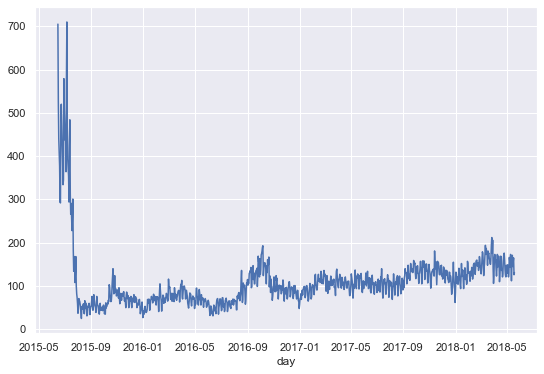

In [8]:
import seaborn as sns

sns.set(rc={'figure.figsize': (9, 6)})
events_trains.groupby('day').user_id.nunique().plot()

Выведем статистику успешного прохождения степов по пользователям

<AxesSubplot:>

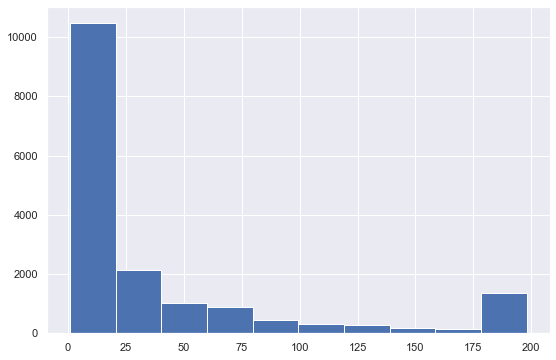

In [9]:
events_trains[events_trains.action == 'passed']\
    .groupby('user_id', as_index=False)\
    .agg({'step_id': 'count'})\
    .rename(columns={'step_id': 'passed_steps'}).passed_steps.hist()

Этот график не совсем корректен, т.к. часть пользователе без passed степов не учитываются.

В процессе решения задачи всегда нужно делать проверки о верности суждения, что мы ничего не потеряли когда мы мержим или агрегируем данные.  
Например в данном случае можно проверить количество всех уникальных пользователей.

Верное решение - использование pivot table.

In [10]:
users_events_data = events_trains.pivot_table(index='user_id', columns='action', values='step_id', aggfunc='count', fill_value=0).reset_index()
users_events_data.head()

action,user_id,discovered,passed,started_attempt,viewed
0,1,1,0,0,1
1,2,9,9,2,10
2,3,91,87,30,192
3,5,11,11,4,12
4,7,1,1,0,1


<AxesSubplot:>

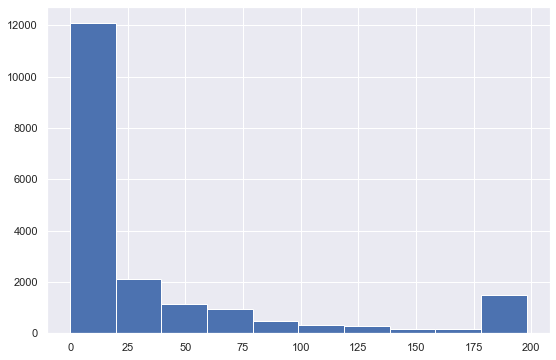

In [11]:
events_trains.pivot_table(index='user_id', columns='action', values='step_id', aggfunc='count', fill_value=0).reset_index().discovered.hist()

Проанализируем данные по количеству попыток прохождения шагов.

In [12]:
submissions_data_train = pd.read_csv('./data/submissions_data_train.csv')
submissions_data_train.head()

,step_id,timestamp,submission_status,user_id
0,31971,1434349275,correct,15853
1,31972,1434348300,correct,15853
2,31972,1478852149,wrong,15853
3,31972,1478852164,correct,15853
4,31976,1434348123,wrong,15853


In [13]:
submissions_data_train['date'] = pd.to_datetime(submissions_data_train.timestamp, unit='s')
submissions_data_train['day'] = submissions_data_train.date.dt.date
submissions_data_train.head()

,step_id,timestamp,submission_status,user_id,date,day
0,31971,1434349275,correct,15853,2015-06-15 06:21:15,2015-06-15
1,31972,1434348300,correct,15853,2015-06-15 06:05:00,2015-06-15
2,31972,1478852149,wrong,15853,2016-11-11 08:15:49,2016-11-11
3,31972,1478852164,correct,15853,2016-11-11 08:16:04,2016-11-11
4,31976,1434348123,wrong,15853,2015-06-15 06:02:03,2015-06-15


Для каждого пользователя расчитаем количество верных submit-ов

In [14]:
user_scores = submissions_data_train.pivot_table(index='user_id', columns='submission_status', values='step_id', aggfunc='count', fill_value=0).reset_index()
user_scores.head()

submission_status,user_id,correct,wrong
0,2,2,0
1,3,29,23
2,5,2,2
3,8,9,21
4,14,0,1


Как делить пользователей на тех еоторые в процессе прохождения курса и на тех, кто прекратил проходить курс?  
Можно воспользоваться эвристическим правилом, например, считать пользователей прекратившими прохождение курса в случае если он не активен 1 месяц.  
Или можно проанализировать распределение перерывов между событиями у участников курса и ответить на вопрос статистически.

Для каждого пользователя расчитаем промежутки в перерывах между степами. Далее просмотрим картину по всем пользователям и примем статистическое решение. 

Удалим ненужные данные

In [15]:
events_trains[['user_id', 'day', 'timestamp']].drop_duplicates(subset=['user_id', 'day',]).head()

,user_id,day,timestamp
0,17632,2015-06-15,1434340848
36,12494,2015-06-15,1434341931
59,442,2015-06-15,1434342029
62,22254,2015-06-15,1434342042
94,6646,2015-06-15,1434342230


Соберём все timestamp-ы и посмотрим на перерывы между ними

In [16]:
import numpy as np

gap_data = events_trains[['user_id', 'day', 'timestamp']].drop_duplicates(subset=['user_id', 'day',])\
    .groupby('user_id')['timestamp'].apply(list)\
    .apply(np.diff).values

In [17]:
gap_data = pd.Series(np.concatenate(gap_data, axis=0))

In [18]:
gap_data = gap_data / (24 * 60 * 60)


<AxesSubplot:>

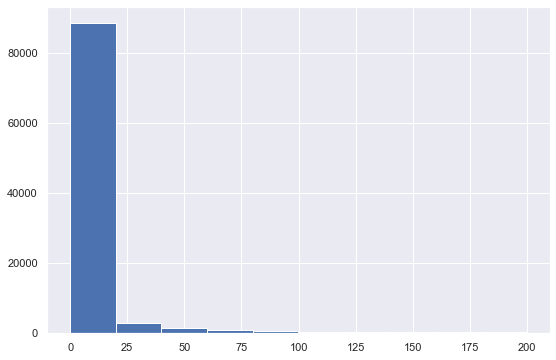

In [19]:
gap_data[gap_data < 200].hist()

In [20]:
gap_data.quantile(0.90)

18.325995370370403

Интерпретация: только 10% пользователей возвращаются к выполнению заданий после 18 дней перерыва.

Если человек не дошёл курс до конца, не получил сертификат и при этом больше чем 30 дней отсутствует на платформе, то будем считать, что он отвалился с курса.

Посчитаем отвалившихся пользователей.  
Для этого посчитаем выведем последний timestamp для каждого пользователя.

In [21]:
users_data = events_trains.groupby('user_id', as_index=False)\
    .agg({'timestamp': 'max'}).rename(columns={'timestamp': 'last_timestamp'})

Далее для каждого пользователя посчитаем количество дней от момента последнего посещения до последнего дня в данных

In [22]:
events_trains.tail()

,step_id,timestamp,action,user_id,date,day
3480698,33375,1526772685,viewed,11677,2018-05-19 23:31:25,2018-05-19
3480699,32815,1526772750,viewed,5198,2018-05-19 23:32:30,2018-05-19
3480700,32815,1526772750,discovered,5198,2018-05-19 23:32:30,2018-05-19
3480701,32815,1526772750,passed,5198,2018-05-19 23:32:30,2018-05-19
3480702,33892,1526772811,viewed,18526,2018-05-19 23:33:31,2018-05-19


In [23]:
now = 1526772811
drop_out_threshold = 30 * 24 * 60 * 60

In [24]:
users_data['is_gone_user'] = (now - users_data.last_timestamp) > drop_out_threshold
users_data.head()

,user_id,last_timestamp,is_gone_user
0,1,1472827464,True
1,2,1519226966,True
2,3,1444581588,True
3,5,1499859939,True
4,7,1521634660,True


Добавим в таблицу число правильных и неправильных попыток

In [25]:
users_data = users_data.merge(user_scores, on='user_id', how='outer')
users_data = users_data.fillna(0)
users_data.head()

,user_id,last_timestamp,is_gone_user,correct,wrong
0,1,1472827464,True,0.0,0.0
1,2,1519226966,True,2.0,0.0
2,3,1444581588,True,29.0,23.0
3,5,1499859939,True,2.0,2.0
4,7,1521634660,True,0.0,0.0


In [26]:
users_data = users_data.merge(users_events_data, how='outer')
users_data.head()

,user_id,last_timestamp,is_gone_user,correct,wrong,discovered,passed,started_attempt,viewed
0,1,1472827464,True,0.0,0.0,1,0,0,1
1,2,1519226966,True,2.0,0.0,9,9,2,10
2,3,1444581588,True,29.0,23.0,91,87,30,192
3,5,1499859939,True,2.0,2.0,11,11,4,12
4,7,1521634660,True,0.0,0.0,1,1,0,1


Добавим количество уникальных дней

In [27]:
users_days = events_trains.groupby('user_id').day.nunique()
users_days = users_days.to_frame().reset_index()

In [28]:
users_data = users_data.merge(users_days, how='outer')
users_data.head()

,user_id,last_timestamp,is_gone_user,correct,wrong,discovered,passed,started_attempt,viewed,day
0,1,1472827464,True,0.0,0.0,1,0,0,1,1
1,2,1519226966,True,2.0,0.0,9,9,2,10,2
2,3,1444581588,True,29.0,23.0,91,87,30,192,7
3,5,1499859939,True,2.0,2.0,11,11,4,12,2
4,7,1521634660,True,0.0,0.0,1,1,0,1,1


Проверяем, что никого не потеряли!

In [29]:
users_data.user_id.nunique() == events_trains.user_id.nunique()

True

Определим, прошел ли пользователь курс - набрал > 170 пройденных шагов

In [30]:
users_data['passed_course'] = users_data.passed > 170

In [31]:
users_data.groupby('passed_course').count()

,user_id,last_timestamp,is_gone_user,correct,wrong,discovered,passed,started_attempt,viewed,day
passed_course,,,,,,,,,,
False,17809,17809,17809,17809,17809,17809,17809,17809,17809,17809
True,1425,1425,1425,1425,1425,1425,1425,1425,1425,1425


Выведем долю прошедших курс

In [32]:
users_data['passed_course'].value_counts(normalize=True)

False    0.925912
True     0.074088
Name: passed_course, dtype: float64

Сохраним предобработанные данные

In [35]:
events_trains.to_pickle('./data/events_data.pkl')
submissions_data_train.to_pickle('./data/submissions_data.pkl')
users_data.to_pickle('./data/students_data.pkl')